# BADLY NEEDS REFACTOR

# Autoencoder ICA

Like I said at the end of my previous post, we might want to learn an invertible function more complicated than a linear map to obtain independent components of our data. Neural networks present a particularly appealing option for this due to their power as function approximators. We have two options here. One, we could learn some unmixing function using a network we very carefully design to be invertible, then very carefully construct the inverse. Alternatively, we can design an autoencoder to try to approximate the identity function and try to get one of the intermediate layers to develop independent features. This would give us the unmixing function (the composition of layers up to that point) as well as our mixing function (the layers from that point on to the end) whose composition is by construction (around) the identity map.

Let's try the latter approach since it sounds more interesting. First, we have to convince ourselves that this is a reasonable thing to ask an autoencoder to do even in the simplest case. Thus, we'll first attempt to do linear ICA on the same data as before using this new approach.

First we load our data, just as before.

In [2]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from typing import Tuple
import os
import glob
from IPython.display import Audio, display

In [2]:
%matplotlib inline

In [3]:
# create convenience function for plotting and playing audio
def show_audio(a: Tuple[int, np.ndarray])->None: # a: (sample_rate, audio_array)
    fig, ax = plt.subplots()
    time_axis = np.linspace(start=0, stop=(len(a[1])/a[0]),num=np.round(len(a[1])))
    ax.plot(time_axis, a[1])
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    display(Audio(a[1], rate=a[0]))

In [4]:
# collect all the wav files
files = glob.glob('../ica/data/mixed_data/*.wav')

In [5]:
samp_rates = []
sound_list = []

In [6]:
# collect sampling frequencies and audio signals
for f in files:
    samp_rate, sound = wavfile.read(f)
    samp_rates.append(samp_rate)
    sound_list.append(sound)

In [7]:
# store as numpy array
audio_array = np.array(sound_list)

Nothing like the sound of mixed up audio clips in the morning!

In [8]:
# we use PyTorch tensors so that later we can easily do gradient descent and other fun things
import torch
from torch import nn
import torch.utils.data as utils
from livelossplot import PlotLosses

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [10]:
torch.manual_seed(1)

Let's define our autoencoder. For now, we'll have a simple linear transformation for both our encoding and decoding steps; these should end up as our mixing and unmixing matrices respectively.

In [11]:
# define our autoencoder architecture
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 4, bias=False))
        self.decoder = nn.Sequential(
            nn.Linear(4, 4, bias=False))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
# zero-mean input
X = audio_array
n, p = X.shape
n_components=min(n,p)
X_mean = X.mean(axis=-1)
X -= X_mean[:, np.newaxis]

In [13]:
del audio_array

In [14]:
# whitening and preprocessing by PCA (i.e. SVD as our data is mean-centered)
# taken from scikit-learn's source code
u, d, _ = linalg.svd(X, full_matrices=False)

del _
K = (u / d).T[:n_components]
del u, d
X1 = K @ X
# Here X1 is white and data
# in X has been projected onto a subspace by PCA
X1 *= np.sqrt(p)

In [15]:
X1 = torch.tensor(X1,dtype=torch.float)

In [16]:
# we permute the input data to better pretend each of our timestamps was drawn independently - helps with convergence
X1 = X1[:,torch.randperm(X1.shape[1], dtype=torch.long)]

In [17]:
# prepare dataloader
audio_dataset = utils.TensorDataset(X1.t())
audio_dataloader = utils.DataLoader(audio_dataset, shuffle=False, pin_memory=True)

In [18]:
# useful functions
def log_likelihood(s_pred: torch.Tensor, W: torch.Tensor)->torch.Tensor:
    return torch.sum(torch.log(prob_s(s_pred))) + torch.log(torch.abs(torch.det(W)))

def sigmoid_der(Y: torch.Tensor)->torch.Tensor:
    a = torch.sigmoid(Y)
    b = 1 - torch.sigmoid(Y)
    return a*b
def prob_s(s: torch.Tensor)->torch.Tensor:
    return sigmoid_der(s)

In [23]:
# some hyperparameters
num_epochs = 20
batch_size = 10
learning_rate = 0.01
# loss parameter for encoder map to independent components
coeff = 6

In [24]:
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.encoder.parameters(), lr=learning_rate)

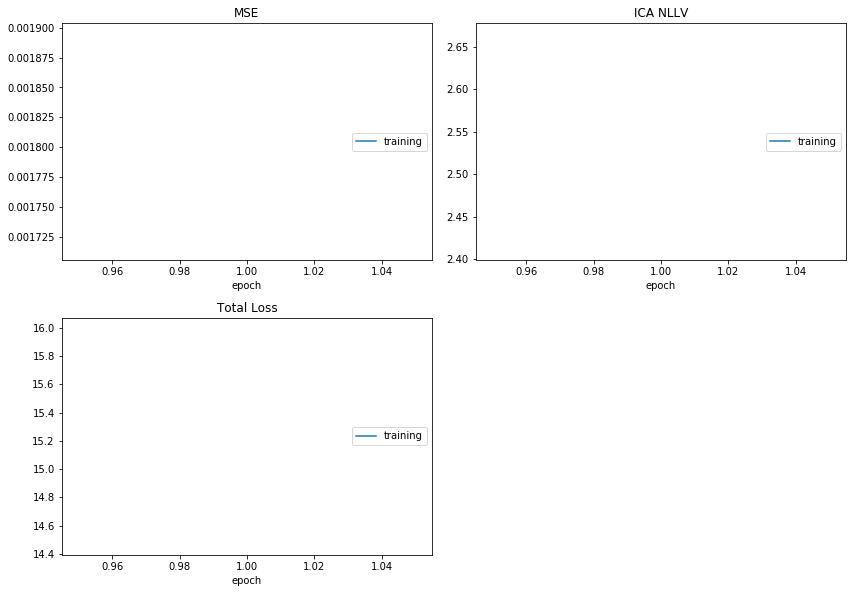

epoch [1/20], loss:15.2321


In [ ]:
liveloss = PlotLosses()
for epoch in range(num_epochs):
    for idx, x_t in enumerate(audio_dataloader):
        x_t = x_t[0]
        x_t = x_t.to(device)
        
        # forward pass
        output = model(x_t)
        s_pred = model.encoder(x_t)
        mse = criterion(output, x_t)
        ica_loss = -log_likelihood(s_pred, next(model.encoder.parameters()))
        loss = coeff*ica_loss + mse
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(idx, 
              'MSE: ', mse.item(), 
              ' ICA NLLV: ', ica_loss.item(), 
              ' Total Loss: ', loss.item(), end='\r'),
    liveloss.update({
        'MSE': mse.item(),
        'ICA NLLV': ica_loss.item(), 
        'Total Loss': loss.item()
    })
    liveloss.draw()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))

In [ ]:
next(model.encoder.parameters())

$$
((KX)^TW^T)^T = WKX
$$

In [ ]:
next(model.encoder.parameters()).cpu() @ torch.tensor(K @ X, dtype=torch.float)

In [ ]:
tst = model.encoder(torch.tensor(K @ X, dtype=torch.float).t().to(device)).t().cpu().detach().numpy()

In [ ]:
tst

In [ ]:
for idx, row in enumerate(tst):
    show_audio((samp_rate, row))

In [ ]:
x_t

In [ ]:
x_t @ next(model.encoder.parameters()).t()

In [ ]:
output

In [ ]:
ica_loss

In [ ]:
next(model.encoder.parameters())

In [ ]:
test = model(torch.Tensor(np.matmul(K, X)).to(device).transpose(0,1)).cpu().detach().numpy()

In [ ]:
test2 = (np.linalg.inv(K) @ test.T).T

In [ ]:
for row in test2.T:
    #print(test2.shape)
    show_audio((samp_rate, row))

In [ ]:
# calculate product of layer weights (composite transform) - check for identity
composite = torch.eye(4, device=device)
for layer_weights in model.parameters():
    composite = torch.mm(composite, layer_weights)
    
print((torch.round(composite).cpu().detach().numpy() == np.eye(4)).all())

In [ ]:
test = model.encoder(torch.Tensor(np.matmul(K, X)).to(device).transpose(0,1)).cpu().detach().numpy()

In [ ]:
test2 = (np.linalg.inv(K) @ test.T).T

In [ ]:
for row in test2.T:
    show_audio((samp_rate, row))